<a href="https://colab.research.google.com/github/andys0tc/TextStyleTransfer/blob/master/BiclassHN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import spacy
import nltk.data
import glob

import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.data import Field, BucketIterator,LabelField
from torchtext import data
from collections import Counter
import spacy
import numpy as np
import re
import random
import math
import time
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import files
uploaded = files.upload()

Saving testset_classification_biclass.csv to testset_classification_biclass.csv
Saving trainset_classification_biclass.csv to trainset_classification_biclass.csv


In [0]:
nlp = spacy.load('en')

TRAIN_SIZE = 0.8
TEST_SIZE = 0.2


In [0]:
def tokenize_input(text):
    return [tok.text for tok in nlp.tokenizer(text)]

In [0]:
"""SRC = Field(tokenize = tokenize_input,
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True)
            """

In [0]:
TEXT = data.Field(tokenize = 'spacy', include_lengths = True)
LABEL = data.LabelField(dtype = torch.float)

In [0]:
#LABEL = data.LabelField(dtype = torch.float)
#LABEL = data.Field(sequential=False)

In [0]:
class DataFrameDataset(data.Dataset):

    def __init__(self, df, fields, is_test=False, **kwargs):
        examples = []
        for i, row in df.iterrows():
            label = row.target if not is_test else None
            text = row.text
            examples.append(data.Example.fromlist([text, label], fields))

        super().__init__(examples, fields, **kwargs)

    @staticmethod
    def sort_key(ex):
        return len(ex.text)

    @classmethod
    def splits(cls, fields, train_df, val_df=None, test_df=None, **kwargs):
        train_data, val_data, test_data = (None, None, None)
        data_field = fields

        if train_df is not None:
            train_data = cls(train_df.copy(), data_field, **kwargs)
        if val_df is not None:
            val_data = cls(val_df.copy(), data_field, **kwargs)
        if test_df is not None:
            test_data = cls(test_df.copy(), data_field, True, **kwargs)

        return tuple(d for d in (train_data, val_data, test_data) if d is not None)


In [0]:
#PATH = '/home/julia/PycharmProjects/seq2seq/data/'
train = pd.read_csv('trainset_classification_biclass.csv')
validation = pd.read_csv('testset_classification_biclass.csv')

In [0]:
fields = [('text',TEXT), ('label',LABEL)]

train_ds, val_ds = DataFrameDataset.splits(fields, train_df=train, val_df=validation)

In [10]:
print(vars(train_ds[15]))

# Check the type 
print(type(train_ds[15]))

{'text': ['Hello', ',', 'Robert', ',', 'Harvey', 'said', '.'], 'label': 0}
<class 'torchtext.data.example.Example'>


In [11]:
MAX_VOCAB_SIZE = 25000

TEXT.build_vocab(train_ds, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = 'glove.6B.200d',
                 unk_init = torch.Tensor.zero_)

.vector_cache/glove.6B.zip: 862MB [06:26, 2.23MB/s]                          
100%|█████████▉| 399557/400000 [00:29<00:00, 13689.15it/s]

In [0]:
LABEL.build_vocab(train_ds)

In [0]:
BATCH_SIZE = 32

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator = data.BucketIterator.splits(
    (train_ds, val_ds), 
    batch_size = BATCH_SIZE,
    sort_within_batch = True,
    device = device)

In [14]:
device

device(type='cuda')

In [0]:
# Hyperparameters
num_epochs = 25
learning_rate = 0.001

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 200
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.2
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token] # padding

In [0]:
class LSTM_net(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout)
        
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        
        self.fc2 = nn.Linear(hidden_dim, 1)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        
        # text = [sent len, batch size]
        
        embedded = self.embedding(text)
        
        # embedded = [sent len, batch size, emb dim]
        
        #pack sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths)
        
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        
        #unpack sequence
        # output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        # output = [sent len, batch size, hid dim * num directions]
        # output over padding tokens are zero tensors
        
        # hidden = [num layers * num directions, batch size, hid dim]
        # cell = [num layers * num directions, batch size, hid dim]
        
        # concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        # and apply dropout
        
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        output = self.fc1(hidden)
        output = self.dropout(self.fc2(output))
                
        #hidden = [batch size, hid dim * num directions]
            
        return output

In [0]:
#creating instance of our LSTM_net class

model = LSTM_net(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT, 
            PAD_IDX)

In [18]:
pretrained_embeddings = TEXT.vocab.vectors

print(pretrained_embeddings.shape)
model.embedding.weight.data.copy_(pretrained_embeddings)

torch.Size([25002, 200])


tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.1765,  0.2921, -0.0021,  ..., -0.2077, -0.2319, -0.1081],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.4477, -0.1177,  0.2338,  ...,  0.4946,  0.2980, -0.1422],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])

In [19]:
#  to initiaise padded to zeros
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.1765,  0.2921, -0.0021,  ..., -0.2077, -0.2319, -0.1081],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.4477, -0.1177,  0.2338,  ...,  0.4946,  0.2980, -0.1422],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])


In [0]:
model.to(device) #CNN to GPU


# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [0]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [0]:
# training function 
def train(model, iterator):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        text, text_lengths = batch.text
        
        optimizer.zero_grad()
        predictions = model(text, text_lengths).squeeze(1)
        loss = criterion(predictions, batch.label)
        acc = binary_accuracy(predictions, batch.label)

        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        

    return epoch_loss / len(iterator), epoch_acc / len(iterator)


In [0]:
def evaluate(model, iterator):
   
    epoch_acc = 0
    model.eval()
    
    with torch.no_grad():
        for batch in iterator:
            text, text_lengths = batch.text
            predictions = model(text, text_lengths).squeeze(1)
            acc = binary_accuracy(predictions, batch.label)
            
            epoch_acc += acc.item()
        
    return epoch_acc / len(iterator)

In [25]:
t = time.time()
loss=[]
acc=[]
val_acc=[]

for epoch in range(num_epochs):
    
    train_loss, train_acc = train(model, train_iterator)
    valid_acc = evaluate(model, valid_iterator)
    
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Acc: {valid_acc*100:.2f}%')
    
    loss.append(train_loss)
    acc.append(train_acc)
    val_acc.append(valid_acc)
    
print(f'time:{time.time()-t:.3f}')


	Train Loss: 0.264 | Train Acc: 86.72%
	 Val. Acc: 95.93%
	Train Loss: 0.196 | Train Acc: 89.67%
	 Val. Acc: 96.46%
	Train Loss: 0.172 | Train Acc: 90.65%
	 Val. Acc: 96.44%
	Train Loss: 0.161 | Train Acc: 91.11%
	 Val. Acc: 96.25%
	Train Loss: 0.154 | Train Acc: 91.39%
	 Val. Acc: 96.45%
	Train Loss: 0.148 | Train Acc: 91.49%
	 Val. Acc: 95.91%
	Train Loss: 0.149 | Train Acc: 91.37%
	 Val. Acc: 96.31%
	Train Loss: 0.149 | Train Acc: 91.58%
	 Val. Acc: 96.15%
	Train Loss: 0.144 | Train Acc: 91.66%
	 Val. Acc: 96.23%
	Train Loss: 0.144 | Train Acc: 91.55%
	 Val. Acc: 95.93%
	Train Loss: 0.144 | Train Acc: 91.69%
	 Val. Acc: 95.93%
	Train Loss: 0.142 | Train Acc: 91.69%
	 Val. Acc: 96.02%
	Train Loss: 0.143 | Train Acc: 91.78%
	 Val. Acc: 95.89%
	Train Loss: 0.141 | Train Acc: 91.84%
	 Val. Acc: 96.23%
	Train Loss: 0.142 | Train Acc: 91.47%
	 Val. Acc: 96.24%
	Train Loss: 0.139 | Train Acc: 91.87%
	 Val. Acc: 95.88%
	Train Loss: 0.139 | Train Acc: 91.94%
	 Val. Acc: 96.06%
	Train Loss: 0

<function matplotlib.pyplot.show>

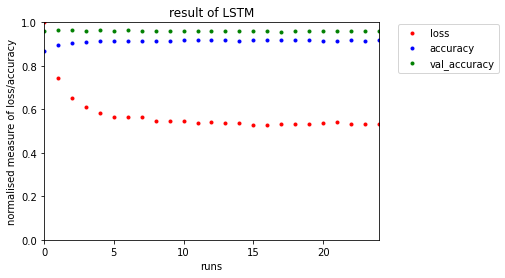

In [27]:
plt.xlabel("runs")
plt.ylabel("normalised measure of loss/accuracy")
x_len=list(range(len(acc)))
plt.axis([0, max(x_len), 0, 1])
plt.title('result of LSTM')
loss=np.asarray(loss)/max(loss)
plt.plot(x_len, loss, 'r.',label="loss")
plt.plot(x_len, acc, 'b.', label="accuracy")
plt.plot(x_len, val_acc, 'g.', label="val_accuracy")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.2)
plt.show